In [1]:
cd ../

c:\Users\eduar\Documents\usp\AMST\ml_timeseries_usp


In [2]:
from src.data.make_dataset import DatasetCreator
from src.data.make_hierarchical_dataset import DatasetHierarchicalAggregator
from src.data.refine_dataset import HierarchicalTimeSeriesOutlierRemover
from src.data.split import hierarchical_train_test_split
from src.features.build_features import FeaturesBuilder
from src.config import load_config
from src.models.tuning import ModelTuning
from src.models.train_model import CreateCanditateModel
from src.evaluation.backtest_evaluation import ModelEvaluate

config = load_config()

if config['cache']:
    print('loading data...')
    df = DatasetCreator(config).load_intermediary()
    Hagg = DatasetHierarchicalAggregator(config,df)
    Y_df = Hagg.load_processed(filename='dataset.parquet')
    S_df = Hagg.load_processed(filename='structure.parquet')
    S_df = Hagg.load_tags(filename='tags.joblib')
    pass
else:
    df = DatasetCreator(config).run() 

    if config['exogen_features'] == 'true':
        df = FeaturesBuilder(df,config).run()
    else:
        pass

    Y_df,S_df,tags = DatasetHierarchicalAggregator(config,df).run()

train,test = hierarchical_train_test_split(Y_df)

2025-11-30 18:54:32,783 - INFO - Config carregado de c:\Users\eduar\Documents\usp\AMST\ml_timeseries_usp\config.yaml
2025-11-30 18:54:33,525 - INFO - Config carregado de c:\Users\eduar\Documents\usp\AMST\ml_timeseries_usp\config.yaml


loading data...
Train: 2022-01-01 → 2025-01-01 (37 meses)
Test (backtest): 2025-02-01 → 2025-07-01 (6 meses)


In [3]:
models = config['models']
cv_config = config['modeling']['cv_config']
candidate_info = {}
candidate_performances = {}
for model in models:
    is_enable = models[model]['enabled']
    #check if model is enable in yaml file
    if is_enable:
        type_model = models[model]['type']
        if type_model == 'mlforecast':
            #Get Tuning info
            model_name = models[model]['regressor']
            fixed_params = models[model]['fixed_params']
            param_space = config['parameter_space'][model]
            mlforecast_params = config['modeling']['mlforecast']
            training_metric = config['modeling']['training_metric']
            compare_metrics = config['modeling']['compare_metrics']
            #Tuning model
            best_value,best_model_params,best_mlforecast_params,mlf_fit_params =\
                  ModelTuning(
                                df=train,
                                config=config,
                                model_name=model_name,
                                fixed_params=fixed_params,
                                param_space=param_space,
                                cv_config=cv_config,
                                mlforecast_params=mlforecast_params,
                                tuning_metric = training_metric
                            ).run()
            
            #create model with best tuning parameters
            candidate,metric,results_metrics = CreateCanditateModel(
                                        df=train,
                                        config=config,
                                        cv_config=cv_config,
                                        type_model=type_model,
                                        model_name=model_name,
                                        metric=best_value,
                                        cv_metric = training_metric,
                                        compare_metrics=compare_metrics,
                                        model_params=best_model_params,
                                        mlf_params=best_mlforecast_params,
                                        mlf_fit_params = mlf_fit_params
                                        ).run()
        else:
            #create model without tuning parameters
            candidate,metric,results_metrics = CreateCanditateModel(
                                        df=train,
                                        config=config,
                                        cv_config=cv_config,
                                        type_model=type_model,
                                        compare_metrics=compare_metrics,
                                        model_name=model_name
                                        ).run()
                
        candidate_info.update({metric:candidate})
        candidate_performances.update({model:results_metrics})

    
    validation_metric,validation_compare_metrics = ModelEvaluate(
                    candidate_model=candidate,
                    model_name=model_name,
                    train=train,
                    test=test,
                    n_months_test=6,
                    validation_metric='rmsse',
                    compare_metrics=compare_metrics,
                    output_plots_path=output_plots_path
                ).run()

[I 2025-11-30 18:54:35,787] A new study created in memory with name: no-name-9ee0b702-2b84-4afb-8ebb-4994c0105e5a
[I 2025-11-30 18:54:36,480] Trial 0 finished with value: 1.3207901448173884 and parameters: {'learning_rate': 0.03574712922600244, 'feature_fraction': 0.9852142919229748, 'bagging_fraction': 0.9195981825434215, 'lambda_l1': 0.0006155564318973012, 'lambda_l2': 1.77071686435378e-07, 'num_leaves': 16, 'max_depth': 3, 'min_data_in_leaf': 18, 'n_estimators': 1923}. Best is trial 0 with value: 1.3207901448173884.
[I 2025-11-30 18:54:37,410] Trial 1 finished with value: 1.073333579872392 and parameters: {'learning_rate': 0.11114989443094977, 'feature_fraction': 0.7061753482887407, 'bagging_fraction': 0.9909729556485982, 'lambda_l1': 0.04566054873446119, 'lambda_l2': 4.997040685255803e-07, 'num_leaves': 18, 'max_depth': 4, 'min_data_in_leaf': 9, 'n_estimators': 1717}. Best is trial 1 with value: 1.073333579872392.
[I 2025-11-30 18:54:38,459] Trial 2 finished with value: 1.261802718

In [ ]:
methods = ['BottomUp','TopDown','MinTrace']#,'MiddleOut']
min_trace_methods = ['wls_var','wls_struct','mint_shrink']

In [85]:
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut, MinTrace

REC_MAPS = {
    'BottomUp':BottomUp,
    'TopDown':TopDown,
    'MiddleOut':MiddleOut,
    'MinTrace':MinTrace
}

def get_reconciliation_function(method):
    return REC_MAPS[method]
    

class DatasetReconciliator:
    def __init__(self,Y_df,S_df,tags,methods,min_trace_methods):
        self.Y_df=Y_df
        self.S_df=S_df
        self.tags=tags
        self.methods
        self.min_trace_methods
    
    def reconciliate(self):
        reconciliers = []
        for method in self.methods:
            method_function = get_reconciliation_function(method)
            if method == "MinTrace":
                for m in self.min_trace_methods:
                    reconciliers.append(method_function(method=m))
            else:
                if method == "TopDown":
                    reconciliers.append(method_function(method='forecast_proportions'))
                elif method == "MiddleOut":
                   reconciliers.append(method_function(top_down_method ='forecast_proportions',middle_level='DEFINIR'))
        return reconciliers
    
    def run(self):
        reconciliers = reconciliate(self)
        return reconciliers
                    
reconciliers = DatasetReconciliator(
                        Y_df=Y_df,
                        S_df=S_df,
                        tags=tags,
                        methods=methods,
                        min_trace_methods=min_trace_methods
                    )


NameError: name 'tags' is not defined

In [59]:
from utilsforecast.losses import rmse, mae, smape, mase,rmsse,bias
from utilsforecast.plotting import plot_series

In [58]:
smape(df_pred,models=['LGBMRegressor'])

,unique_id,LGBMRegressor
0,total,0.045800
1,total/CD1,0.193233
2,total/CD2,0.173060
3,total/CD3,0.157174


In [69]:
fig = plot_series(df_pred,df_pred[['unique_id','ds','LGBMRegressor']])

In [74]:
fig.savefig?

Signature: fig.savefig(fname, *, transparent=None, **kwargs)
Docstring:
Save the current figure as an image or vector graphic to a file.

Call signature::

  savefig(fname, *, transparent=None, dpi='figure', format=None,
          metadata=None, bbox_inches=None, pad_inches=0.1,
          facecolor='auto', edgecolor='auto', backend=None,
          **kwargs
         )

The available output formats depend on the backend being used.

Parameters
----------
fname : str or path-like or binary file-like
    A path, or a Python file-like object, or
    possibly some backend-dependent object such as
    `matplotlib.backends.backend_pdf.PdfPages`.

    If *format* is set, it determines the output format, and the file
    is saved as *fname*.  Note that *fname* is used verbatim, and there
    is no attempt to make the extension, if any, of *fname* match
    *format*, and no extension is appended.

    If *format* is not set, then the format is inferred from the
    extension of *fname*, if there 

In [52]:
df_pred

,unique_id,ds,LGBMRegressor
0,total,2025-02-01,148973.937500
1,total,2025-03-01,151501.734375
2,total,2025-04-01,158499.078125
3,total,2025-05-01,158499.078125
4,total,2025-06-01,158151.203125
5,total,2025-07-01,158151.203125
6,total/CD1,2025-02-01,38223.457031
7,total/CD1,2025-03-01,42093.750000
8,total/CD1,2025-04-01,45885.605469
9,total/CD1,2025-05-01,62448.890625


In [43]:
candidate.predict(6)

,unique_id,ds,LGBMRegressor
0,total,2025-02-01,148973.937500
1,total,2025-03-01,151501.734375
2,total,2025-04-01,158499.078125
3,total,2025-05-01,158499.078125
4,total,2025-06-01,158151.203125
5,total,2025-07-01,158151.203125
6,total/CD1,2025-02-01,38223.457031
7,total/CD1,2025-03-01,42093.750000
8,total/CD1,2025-04-01,45885.605469
9,total/CD1,2025-05-01,62448.890625


In [47]:
df.predict_future(candidate)

TypeError: ModelEvaluate.predict_future() takes 1 positional argument but 2 were given

In [42]:
df = ModelEvaluate(
                candidate_model=candidate,
                train=train,
                test=test,
                n_months_test=6,
                validation_metric='rmsse'
             )

In [23]:
df

TypeError: 'ModelEvaluate' object is not callable

In [14]:
config['paths']['plots']

{'plots_path': 'plots/'}

plots/model_comparison.png
Tabela salva com sucesso!


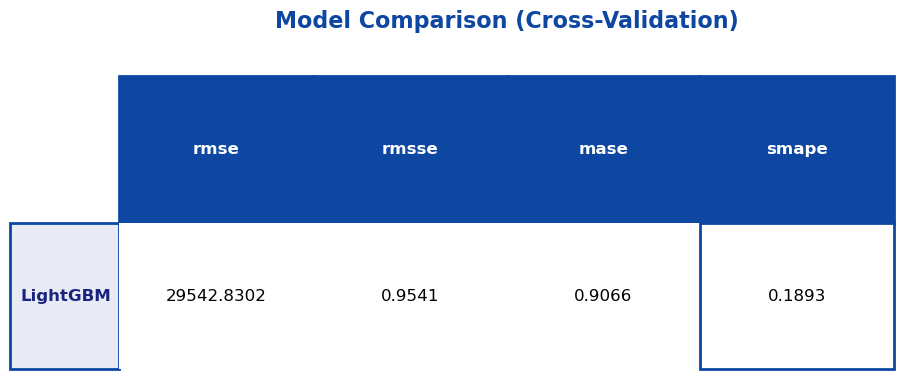

In [15]:
ModelEssembler(config=config,
                candidate_info=candidate_info,
                candidate_performances=candidate_performances
                ).run()

In [9]:
output_plots_path

{'plots_path': 'plots/'}

In [10]:
output_plots_path = config['paths']['plots']['plots_path']
filename = 'model_comparison.png'
os.path.join(output_plots_path, filename)

'plots/model_comparison.png'

In [ ]:
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [ ]:
def tabela_academica_sem_grid(
    resultados: dict,
    titulo: str = "Comparação de Desempenho dos Modelos",
    salvar: bool = True
):
    import pandas as pd
    import matplotlib.pyplot as plt
    df = pd.DataFrame(resultados).T.round(4)

    fig, ax = plt.subplots(figsize=(10, 3.8))
    ax.axis('off')

    table = ax.table(
        cellText=df.values,
        rowLabels=df.index,
        colLabels=df.columns,
        cellLoc='center',
        loc='center',
        bbox=[0, 0, 1, 1]
    )

    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 2.6)
    
    # Remove TODAS as bordas internas
    for key, cell in table.get_celld().items():
        cell.set_linewidth(0)
        cell.set_edgecolor('white')

    # Cores
    cor_cabecalho = "#0D47A1"      # azul escuro
    cor_primeira_coluna = "#E8EAF6"  # azul bem claro

    # === CABEÇALHO (modelos) ===
    for j, modelo in enumerate(df.columns):
        cell = table[(0, j)]
        cell.set_linewidth(2)
        cell.set_edgecolor(cor_cabecalho)
        cell.get_text().set_color("white")
        cell.get_text().set_weight('bold')
        cell.set_facecolor(cor_cabecalho)

    # === PRIMEIRA COLUNA (métricas) ===
    for i, metrica in enumerate(df.index):
        cell = table[(i + 1, -1)]  # última coluna = nome da métrica
        cell.set_linewidth(2)
        cell.set_edgecolor(cor_cabecalho)
        cell.set_facecolor(cor_primeira_coluna)
        cell.get_text().set_weight('bold')
        cell.get_text().set_color("#1A237E")

    # === BORDA EXTERNA SUPERIOR E INFERIOR ===
    n_rows = len(df.index) + 1
    n_cols = len(df.columns)

    # Linha superior (acima do cabeçalho)
    for j in range(n_cols):
        table[(0, j)].set_linewidth(2)
        table[(0, j)].set_edgecolor(cor_cabecalho)

    # Linha inferior (abaixo da última linha)
    for j in range(-1, n_cols):
        table[(i, n_cols-1)].set_linewidth(2)
        table[(n_rows - 1, j)].set_edgecolor(cor_cabecalho)

    # Borda esquerda (só na coluna de métricas)
    for i in range(n_rows):
        table[(i, n_cols-1)].set_linewidth(2)
        table[(i, n_cols-1)].set_edgecolor(cor_cabecalho)

    # Borda direita (última coluna de valores)
    for i in range(n_rows):
        table[(i, n_cols - 1)].set_linewidth(2)
        table[(i, n_cols - 1)].set_edgecolor(cor_cabecalho)

    plt.title(titulo, fontsize=16, fontweight='bold', pad=35, color="#0D47A1")

    if salvar:
        plt.savefig("tabela_final_limpa.png", dpi=400, bbox_inches='tight', facecolor='white')
        plt.savefig("tabela_final_limpa.pdf", bbox_inches='tight', facecolor='white')
        print("Tabela salva com sucesso!")

    plt.show()

Tabela salva com sucesso!


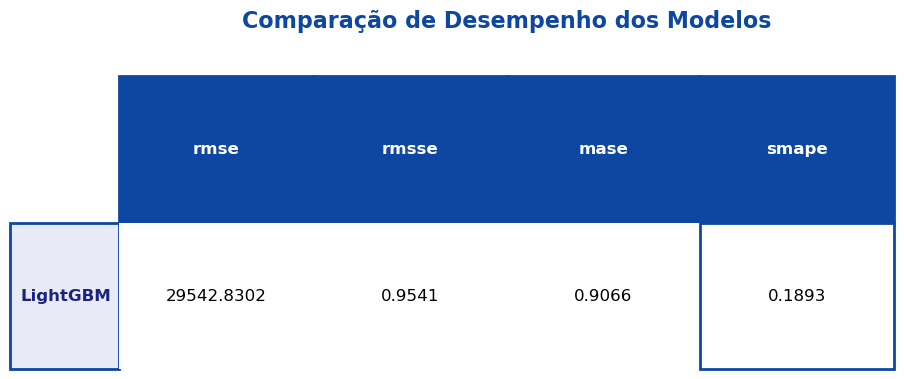

In [30]:
tabela_academica_sem_grid(candidate_performances)

In [17]:
import matplotlib.pyplot as plt

In [9]:
# Arredonda
df = df.round(4)

# Encontra o melhor (menor) em cada métrica
melhores = df.idxmin()  # retorna o modelo com menor valor por coluna

fig, ax = plt.subplots(figsize=(10, 0.4 * len(df) + 1.5))
ax.axis('tight')
ax.axis('off')

# Cria a tabela
table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    rowLabels=df.index,
    cellLoc='center',
    loc='center',
    bbox=[0, 0, 1, 1]
)

# Estilo acadêmico profissional
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 2.2)

# Cabeçalho em negrito e fundo cinza
for (i, col) in enumerate(df.columns):
    table[(0, i)].get_text().set_weight('bold')
    table[(0, i)].set_facecolor("#404040")
    table[(0, i)].get_text().set_color("white")

# Linhas dos modelos
for i, modelo in enumerate(df.index):
    table[(i+1, -1)].get_text().set_weight('bold')  # nome do modelo em negrito
    
    # Destaca o MELHOR em cada coluna
    for j, metrica in enumerate(df.columns):
        cell = table[(i+1, j)]
        valor = df.loc[modelo, metrica]
        
        if destaque_melhor and modelo == melhores[metrica]:
            cell.set_facecolor(melhor_cor)
            cell.get_text().set_color("white")
            cell.get_text().set_weight('bold')
        elif destaque_melhor and modelo == df.nsmallest(2, metrica).index[1]:
            cell.set_facecolor(segundo_melhor_cor)
            cell.get_text().set_color("white")

# Título
plt.title(titulo, fontsize=16, fontweight='bold', pad=30)

# Salva em alta resolução (perfeito pra LaTeX/PDF)
plt.savefig("tabela_comparacao_modelos.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig("tabela_comparacao_modelos.pdf", bbox_inches='tight', facecolor='white')
plt.show()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x00000222EF04A8C0> (for post_execute), with arguments args (),kwargs {}:


ValueError: Image size of 1000x79758150 pixels is too large. It must be less than 2^23 in each direction.

ValueError: Image size of 1000x79758150 pixels is too large. It must be less than 2^23 in each direction.

<Figure size 1000x7.97582e+07 with 1 Axes>

In [4]:
results_metrics

{'rmse': 29542.83022314835,
 'rmsse': 0.9540697196803619,
 'mase': 0.9066038440644106,
 'smape': 0.18933553189280028}

In [39]:
model,metric,results_metrics = CreateCanditateModel(
                                        df=train,
                                        config=config,
                                        cv_config=cv_config,
                                        type_model=type_model,
                                        model_name=model_name,
                                        metric=best_value,
                                        cv_metric = training_metric,
                                        compare_metrics=compare_metrics,
                                        model_params=best_model_params,
                                        mlf_params=best_mlforecast_params,
                                        mlf_fit_params = mlf_fit_params
                                        ).run()

KeyError: 'metric'

In [43]:
best_value

1.0243119478493985

In [42]:
results_metrics

{'rmse': 29542.83022314835,
 'rmsse': 0.9540697196803619,
 'mase': 0.9066038440644106,
 'smape': 0.18933553189280028}

In [ ]:
df_cv = models_info[0.24036374675934324].cross_validation(
                                     df=train,
                                     h=6,
                                     n_windows=12,
                                     step_size=1
                                     )

In [22]:
from utilsforecast.losses import rmse, mae, smape, mase, scaled_crps, mqloss,rmsse

In [42]:
import utilsforecast.losses as ls

In [29]:
df_cv

,unique_id,ds,cutoff,y,LGBMRegressor
0,total,2023-09-01,2023-08-01,53509,39432.136719
1,total,2023-10-01,2023-08-01,48610,39432.136719
2,total,2023-11-01,2023-08-01,59469,39432.136719
3,total,2023-12-01,2023-08-01,116941,39432.136719
4,total,2024-01-01,2023-08-01,42857,19741.742188
...,...,...,...,...,...
283,total/CD3,2024-09-01,2024-07-01,4275,5452.494141
284,total/CD3,2024-10-01,2024-07-01,4121,4913.587891
285,total/CD3,2024-11-01,2024-07-01,4310,4913.587891
286,total/CD3,2024-12-01,2024-07-01,7337,5644.232910


In [30]:
model_name

'LGBMRegressor'

In [ ]:
met1 = smape(df_cv, models=[model_name])[model_name].mean()
met2 = rmse(df_cv, models=[model_name])[model_name].mean()
met3 = mase(df_cv, train_df=train, seasonality =12,models=[model_name])[model_name].mean()
met4 = rmsse(df_cv, train_df=train, seasonality =12,models=[model_name])[model_name].mean()
 # Métrica para ensemble

In [41]:
met1

0.27821147438940275

In [34]:
met2

30044.114749498873

In [33]:
met3

1.0197648022485062

In [39]:
met4

0    0.775147
1    1.552146
2    0.690697
3    1.365662
Name: LGBMRegressor, dtype: float64

In [ ]:
df_cv

In [14]:
model

'SeasonalNaive'